In [1]:
### BELOW IS THE CONNECTION CODE TO BASEBALL COMPUTER ###

# Duckdb is a SQL engine that allows us to execute powerful, analytics-friendly
# queries against local or remote databases and flat files.
import duckdb
import pandas as pd
import numpy as np

# Create a database file on disk
conn = duckdb.connect('example.db')
# Enable remote access
conn.sql("INSTALL httpfs")
conn.sql("LOAD httpfs")
# This database file points to files totaling multiple GBs,
# but it's only about 300KB itself. The `ATTACH` command
# gives us access to views that sit on top of remote Parquet files.
try:
  conn.sql("ATTACH 'https://data.baseball.computer/dbt/bc_remote.db' (READ_ONLY)")
except duckdb.BinderException:
  # This command will fail if you run it more than once because it already exists,
  # in which case we don't need to do anything
  pass

conn.sql("USE bc_remote")
conn.sql("USE main_models")

pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import linear_model,metrics, neural_network

In [2]:
date = '2018-01-01'

In [3]:
def grab_writeHistory(date):
        ### GRAB ALL BATTING STATS FROM BASEBALL COMPUTER ###
        query = """ 
                SELECT a.*, b.date
                FROM main_models.event_batting_stats as a
                LEFT JOIN main_models.event_states_full as b on a.event_key = b.event_key
                WHERE b.date >= '{0}'
                ORDER BY b.date
        """.format(date)
        b_hist: pd.DataFrame = conn.sql(query).df()
        b_hist = b_hist.sort_values(['date']).drop('event_key', axis=1)
        b_hist = b_hist.groupby(['game_id', 'batter_id', 'pitcher_id', 'batting_team_id', 'fielding_team_id', 'batter_lineup_position', 'date']).sum()
        b_hist = b_hist.reset_index().sort_values(['date', 'game_id'])

        ### GRAB ALL PITCHING STATS FROM BASEBALL COMPUTER ###
        query = """ 
                SELECT a.player_id, a.game_id, a.team_id, a.games_started, a.innings_pitched, b.date
                FROM main_models.player_game_pitching_stats as a
                LEFT JOIN main_models.stg_games as b on a.game_id = b.game_id
                WHERE b.date >= '{0}'
                ORDER BY b.date
        """.format(date)
        p_hist: pd.DataFrame = conn.sql(query).df()
        p_hist = p_hist.sort_values(['date', 'game_id'])

        ### COMBINE PITCHING AND BATTING HISTORY ###
        all_hist = pd.merge(b_hist, p_hist, how='left', left_on=['game_id', 'fielding_team_id', 'date', 'pitcher_id'], right_on=['game_id', 'team_id', 'date', 'player_id'])
        all_hist = all_hist.drop(['player_id', 'team_id'], axis=1)
        all_hist['pitcher_id'][all_hist['games_started']==0] = 'RP'
        all_hist = all_hist.groupby(['game_id', 'batter_id', 'pitcher_id', 'batting_team_id', 'fielding_team_id', 'batter_lineup_position', 'date']).sum().reset_index()
        all_hist = all_hist.sort_values(['date', 'game_id', 'batter_lineup_position'])
        all_hist.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\batting_history.csv", index=False)

In [4]:
### CREATES A FILE THAT DOES NOT DISTINGUISH BETWEEN RELIEF AND STARTER TO SEE GAME STATS ###
df = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\batting_history.csv")
df = df.drop('pitcher_id', axis=1).groupby(['game_id','batter_id','batting_team_id','fielding_team_id','batter_lineup_position','date'], as_index=False).sum()
df.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\aggregated_batting_history.csv", index=False)

In [4]:
def categorizePitchers(season):
        ### GRAB LAST 5 SEASONS OF PITCHER STATS, CREATE CATEGORIES FOR EACH ###
        query = """ 
                SELECT a.*, b.throws
                FROM main_models.metrics_player_season_league_pitching as a
                LEFT JOIN main_models.stg_bio as b on a.player_id = b.player_id
                WHERE a.season >= '{0}'
        """.format(season)
        df_pitch: pd.DataFrame = conn.sql(query).df()
        df_pitch= df_pitch[['player_id', 'season', 'outs_recorded', 'at_bats', 'hits', 'singles', 'doubles', 'triples', 'home_runs', 'total_bases', 'hit_by_pitches', 'batting_outs', 'pitches', 'walks', 'strikeouts', 'on_base_opportunities', 'on_base_successes', 'trajectory_fly_ball', 'trajectory_ground_ball', 'trajectory_pop_up', 'swings', 'throws']]
        df_pitch = df_pitch.groupby(['player_id', 'season', 'throws']).sum().reset_index()
        df_pitch['throws'][df_pitch['throws']=='L'], df_pitch['throws'][df_pitch['throws']=='R'], df_pitch['throws'][df_pitch['throws']=='B'] = 1, 2, 3

        ### CREATE CATEGORIES FOR EACH PITCHER USING KMEANS ###
        df_pitch = df_pitch[df_pitch['season']!=2020]
        test_df = df_pitch.drop(['player_id', 'season'], axis=1).fillna(0)
        kmeans = KMeans(n_clusters=5)
        kmeans.fit(test_df)
        df_pitch['Categories'] = kmeans.labels_
        df_pitch.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\pitcher_cat.csv", index=False)

<BarContainer object of 5 artists>

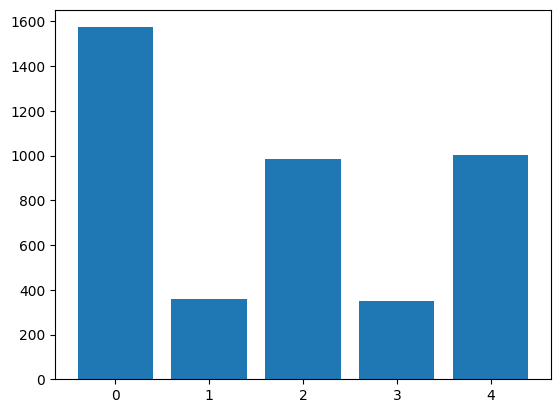

In [30]:
### GRAPH OF PITCHER DISTRIBUTIONS ###
pitchers = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\pitcher_cat.csv")
plt.bar(x=[0,1,2,3,4], height=pitchers['Categories'].value_counts().reset_index().sort_values('Categories')['count'])

In [2]:
df = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\batting_history.csv")
df1 = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\pitcher_cat.csv")
### GET BATTER'S LAST 8 GAMES AGAINST SPECIFIC PITCHER OR PITCHER IN SAME CATEGORY ###
def get_last8(batter, pitcher, date, df, df1):
    df = df[pd.to_datetime(df['date']) < date]
    df1 = df1[df1['season'] <= date.year]
    df1 = df1.drop_duplicates(['player_id'], keep='last')[['player_id', 'Categories']]
    df = pd.merge(df, df1, left_on='pitcher_id', right_on='player_id', how='left')
    temp_df = df[df['batter_id']==batter]
    obs = temp_df.loc[df['pitcher_id']==pitcher][-8:]
    if len(obs) < 8:
        index = 8 - len(obs)
        try:
            pitcher_cat = df1.loc[df1['player_id']==pitcher]['Categories'].to_list()[0]
            obs2 = temp_df.loc[(temp_df['pitcher_id']!=pitcher)&(temp_df['Categories']==pitcher_cat)][-index:]
            obs = pd.concat([obs, obs2])
        except Exception as e:
            print('No data on pitcher, no comparisons can be made. Batter excluded was:', batter)
            return 'NA'
    obs = obs.drop(['game_id', 'pitcher_id', 'batting_team_id', 'fielding_team_id', 'date', 'games_started', 'innings_pitched', 'player_id', 'Categories'], axis=1).groupby('batter_id').mean().reset_index()        
    return obs

### GET BATTER'S STATS FOR CURRENT GAME (ONLY TO BE USED FOR TRAINING MODEL) ###
def get_current(batter, pitcher, date, df):
    obs = df[(df['batter_id']==batter)&(df['pitcher_id']==pitcher)&(pd.to_datetime(df['date'])==date)]
    return obs.drop(['game_id', 'pitcher_id', 'batting_team_id', 'fielding_team_id', 'date', 'games_started', 'innings_pitched'], axis=1)
#get_current('carrc005', 'kersc001', pd.to_datetime('2023-04-07'))
get_last8('carrc005', 'kersc001', pd.to_datetime('2023-04-07'), df, df1)

,batter_id,batter_lineup_position,plate_appearances,at_bats,hits,singles,doubles,triples,home_runs,total_bases,infield_hits,strikeouts,walks,intentional_walks,hit_by_pitches,sacrifice_flies,sacrifice_hits,reached_on_errors,reached_on_interferences,ground_rule_doubles,inside_the_park_home_runs,on_base_opportunities,on_base_successes,runs_batted_in,grounded_into_double_plays,double_plays,triple_plays,batting_outs,outs_on_play,left_on_base,left_on_base_with_two_outs
0,carrc005,5.75,2.25,2.25,0.375,0.125,0.125,0.0,0.125,0.875,0.0,0.625,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,2.25,0.375,0.125,0.0,0.0,0.0,1.875,1.75,0.625,0.25


In [6]:
### GET LINEUPS FOR A GAME (MAY NEED CHANGED WHEN SEASON STARTS, NOT SURE HOW DATABASE UPDATES) ###
def getLineups(date):
        query = """ 
                SELECT a.*
                FROM main_models.game_starting_lineups as a
                LEFT JOIN main_models.stg_games as b on a.game_id = b.game_id
                WHERE b.date >= '{0}'
                ORDER BY b.date
        """.format(date)
        lineups: pd.DataFrame = conn.sql(query).df()
        lineups.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\lineups.csv", index=False)

In [7]:
# batting_hist = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\batting_history.csv")
# pitcher_cat = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\pitcher_cat.csv")
# query = """ 
#         SELECT a.*, b.date
#         FROM main_models.game_starting_lineups as a
#         LEFT JOIN main_models.stg_games as b on a.game_id = b.game_id
#     """
# df: pd.DataFrame = conn.sql(query).df()

def createDataframes(x, y, batting_hist, pitcher_cat, df):
    date = pd.to_datetime(df['date'].iloc[0])
    away_pitcher, home_pitcher = df['fielding_map_away'].iloc[0]['value'].pop(0), df['fielding_map_home'].iloc[0]['value'].pop(0)
    away_batters, home_batters = df['lineup_map_away'].iloc[0]['value'], df['lineup_map_home'].iloc[0]['value']
    
    if len(away_batters) == 10:
        away_batters.remove(away_pitcher)
    if len(home_batters) == 10:
        home_batters.remove(home_pitcher)

    for batter in away_batters:
        x_value = get_last8(batter, home_pitcher, date, batting_hist, pitcher_cat)
        if type(x_value) != str:
            x.append(x_value.drop('batter_id',axis=1).to_numpy())
            y.append(get_current(batter, home_pitcher, date, batting_hist).drop('batter_id', axis=1).to_numpy())
        else:
            break
    for batter in home_batters:
        x_value = get_last8(batter, away_pitcher, date, batting_hist, pitcher_cat)
        if type(x_value) != str:
            x.append(x_value.drop('batter_id', axis=1).to_numpy())
            y.append(get_current(batter, away_pitcher, date, batting_hist).drop('batter_id', axis=1).to_numpy())
        else:
            break
x, y = [], []
#createDataframes('PIT201905080', x, y)
#x, y = np.array(x).reshape([18,30]), np.array(y).reshape([18,30])

In [36]:
x, y = [], []
game_ids = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\lineups.csv")['game_id'].to_list()
game_ids = game_ids[-5:]
#game_ids = game_ids[3000:3020]
query = """ 
        SELECT a.*, b.date
        FROM main_models.game_starting_lineups as a
        LEFT JOIN main_models.stg_games as b on a.game_id = b.game_id
    """
df: pd.DataFrame = conn.sql(query).df()
batting_hist = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\batting_history.csv")
pitcher_cat = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\pitcher_cat.csv")

for i, game_id in enumerate(game_ids):
    lineups = df[df['game_id']==game_id]
    createDataframes(x, y, batting_hist, pitcher_cat, lineups)
    if i % 500 == 0:
        print('Save {0}:'.format(i/500), i)
        to_file = pd.DataFrame()
        to_file['inputs'], to_file['outputs'] = x, y
        #to_file.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\input-outputs5.csv", index=False)

# for i, j in enumerate(x):
#     if len(j)==0:
#         del x[i]
#         del y[i]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Save 0.0: 0


In [58]:
x, y = np.array(x).reshape([len(x), 30]), np.array(y).reshape([len(y), 30])

x_train, y_train = x[0:180], y[0:180]
x_test, y_test = x[180:], y[180:]

regr = linear_model.LinearRegression(positive=True)
regr.fit(x_train, y_train)
y_pred = np.around(regr.predict(x_test))

In [59]:
metrics.mean_squared_error(y_test, y_pred)

0.7041596913344829

CREATING SCRAPER TO GET CURRENT DAY LINEUPS

In [3]:
from urllib.request import Request,urlopen
import requests
from bs4 import BeautifulSoup as soup
from time import sleep
from io import StringIO
import re
from unidecode import unidecode
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [4]:
teams_abbr = {"Arizona D'Backs" : 'ARI',
    "Los Angeles Dodgers" : 'LAD',
    "San Diego Padres": 'SDP',
    "San Francisco Giants": 'SFG',
    "Colorado Rockies": 'COL',
    "Houston Astros" : 'HOU',
    "Texas Rangers" : 'TEX',
    "Seattle Mariners": 'SEA',
    "Los Angeles Angels": 'LAA',
    "Oakland Athletics": 'OAK',
    "Milwaukee Brewers": 'MIL',
    "Chicago Cubs": 'CHC',
    "Cincinnati Reds": 'CIN',
    "Pittsburgh Pirates": 'PIT',
    "St. Louis Cardinals": 'STL',
    "Minnesota Twins": 'MIN',
    "Detroit Tigers": 'DET',
    "Cleveland Guardians": 'CLE',
    "Chicago White Sox": 'CHW',
    "Kansas City Royals": 'KCR',
    "Atlanta Braves": 'ATL',
    "Philadelphia Phillies": 'PHI',
    "Miami Marlins": 'MIA',
    "New York Mets": 'NYM',
    "Washington Nationals": 'WSN',
    "Baltimore Orioles": 'BAL',
    "Tampa Bay Rays": 'TBR',
    "Toronto Blue Jays": 'TOR',
    "New York Yankees": 'NYY',
    "Boston Red Sox": 'BOS'}
abr_convert = teams_abbr = {"AZ" : 'ARI',
    "LAD" : 'LAD',
    "SD": 'SDP',
    "SF": 'SFG',
    "COL": 'COL',
    "HOU" : 'HOU',
    "TEX" : 'TEX',
    "SEA": 'SEA',
    "LAA": 'LAA',
    "OAK": 'OAK',
    "MIL": 'MIL',
    "CHC": 'CHC',
    "CIN": 'CIN',
    "PIT": 'PIT',
    "STL": 'STL',
    "MIN": 'MIN',
    "DET": 'DET',
    "CLE": 'CLE',
    "CWS": 'CHW',
    "KC": 'KCR',
    "ATL": 'ATL',
    "PHI": 'PHI',
    "MIA": 'MIA',
    "NYM": 'NYM',
    "WSH": 'WSN',
    "BAL": 'BAL',
    "TB": 'TBR',
    "TOR": 'TOR',
    "NYY": 'NYY',
    "BOS": 'BOS'}

def getSoup(url):
    req = Request(url=url,headers={'User-Agent': 'Mozilla/6.0'})
    uClient = urlopen(req)
    #grabs everything from page
    html = uClient.read()
    #close connection
    uClient.close()
    #does HTML parsing
    parse = soup(html, "html.parser")
    return parse

def get_40man(team, season, ids):
    text = getSoup("https://www.baseball-reference.com/teams/{0}/{1}-roster.shtml#all_the40man".format(team, season))
    sleep(2)
    roster = StringIO(unidecode(str(text.find('table', {'id':'the40man'}))))
    bb_ref_id = [str(x).split('data-append-csv="')[1][0:9].replace('"', '') for x in text.findAll('td', {'class':'left'})]
    df = pd.read_html(roster)[0]
    df = df.drop(df.index.to_list()[-1])
    df['baseball_ref_id'] = bb_ref_id
    bb_cpu_ids = []
    for player_id in bb_ref_id:
        if player_id in ids['baseball_reference_player_id'].to_list():
            bb_cpu_ids.append(ids[ids['baseball_reference_player_id']==player_id]['retrosheet_player_id'].to_list()[0])
        else:
            bb_cpu_ids.append('NA')        
    df['baseball_cpu_id'] = bb_cpu_ids
    df.insert(3, 'Team', team)
    df.insert(3, 'Season', season)
    if 'roster' + str(2024) + '.csv' in os.listdir(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone"):
        df.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\roster" + str(season) + ".csv", index=False, header=False, mode='a')
    else:
        df.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\roster" + str(season) + ".csv", index=False)

In [6]:
query = """ 
        SELECT retrosheet_player_id, baseball_reference_player_id
        FROM main_models.stg_people
        """
ids: pd.DataFrame = conn.sql(query).df()
for team in teams_abbr:
    get_40man(teams_abbr[team], '2024', ids)

In [5]:
def getCurrentDayLineup():
    text = getSoup('https://www.mlb.com/starting-lineups')
    #text = getSoup('https://www.mlb.com/starting-lineups/2024-04-27')
    away_team = text.findAll('div', {'class':"starting-lineups__team-logo-image starting-lineups__team-logo-image--away"})
    away_team = [str(x).split('data-tri-code="')[1][0:3].replace('"','') for x in away_team]
    away_team = [abr_convert.get(x) for x in away_team]

    home_team = text.findAll('div', {'class':"starting-lineups__team-logo-image starting-lineups__team-logo-image--home"})
    home_team = [str(x).split('data-tri-code="')[1][0:3].replace('"', '') for x in home_team]
    home_team = [abr_convert.get(x) for x in home_team]

    away_pitchers = text.findAll('div', {'class':'starting-lineups__pitcher-name'})
    away_pitchers = [re.search('">(.*)</a>', unidecode(str(x))).group(1) for x in away_pitchers if 'TBD' not in str(x)]

    home_pitchers = away_pitchers[1::2]
    del away_pitchers[1::2]

    away_hitters = text.findAll('ol', {'class':'starting-lineups__team starting-lineups__team--away'})
    del away_hitters[1::2]
    away_hitters = [re.findall('target="">(.*)</a>', unidecode(str(x))) for x in away_hitters if 'TBD' not in str(x)]

    home_hitters = text.findAll('ol', {'class':'starting-lineups__team starting-lineups__team--home'})
    del home_hitters[1::2]
    home_hitters = [re.findall('target="">(.*)</a>', unidecode(str(x))) for x in home_hitters if 'TBD' not in str(x)]
    return away_hitters, home_hitters, away_pitchers, home_pitchers, away_team, home_team

def convertNames(away_hitters, home_hitters, away_pitchers, home_pitchers, away_team, home_team):   
    ### THINK IT WILL WORK, SPRING TRAINING MESSING WITH 40 MAN ###
    ### REPLACES NAME WITH BASEBALL CPU ID ###
    baseball_cpu_ids = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\roster2024.csv")
    for team, lineup in enumerate(away_hitters):
        for batter in range(len(lineup)):
            try:
                lineup[batter] = baseball_cpu_ids[(baseball_cpu_ids['Name']==lineup[batter])&(baseball_cpu_ids['Team']==away_team[team])]['baseball_cpu_id'].to_list()[0]
            except:
                print('Unknown BatterID:',lineup[batter])
                lineup[batter] = np.nan
    for team, lineup in enumerate(home_hitters):
        for batter in range(len(lineup)):
            try:
                lineup[batter] = baseball_cpu_ids[(baseball_cpu_ids['Name']==lineup[batter])&(baseball_cpu_ids['Team']==home_team[team])]['baseball_cpu_id'].to_list()[0]
            except:
                print('Unknown BatterID:',lineup[batter])
                lineup[batter] = np.nan
    for pitcher in range(len(away_pitchers)):
        try:
            away_pitchers[pitcher] = baseball_cpu_ids[(baseball_cpu_ids['Name']==away_pitchers[pitcher])&(baseball_cpu_ids['Team']==away_team[pitcher])]['baseball_cpu_id'].to_list()[0]
        except:
            print('Unknown PitcherID:',away_pitchers[pitcher])
            away_pitchers[pitcher] = np.nan
    for pitcher in range(len(home_pitchers)):
        try:
            home_pitchers[pitcher] = baseball_cpu_ids[(baseball_cpu_ids['Name']==home_pitchers[pitcher])&(baseball_cpu_ids['Team']==home_team[pitcher])]['baseball_cpu_id'].to_list()[0]
        except:
            print('Unknown PitcherID:',home_pitchers[pitcher])
            home_pitchers[pitcher] = np.nan

def collectInput(x, batting_hist, pitcher_cat, home_pitcher, away_pitcher, home_batters, away_batters):
    date = pd.to_datetime('today')

    for batter in away_batters:
        x_value = get_last8(batter, home_pitcher, date, batting_hist, pitcher_cat)
        if type(x_value) != str:
            x.append(x_value.drop('batter_id',axis=1).to_numpy())
        else:
            x.append([])
            print('Batter Lineup Position Excluded:', away_batters.index(batter))
            continue
    for batter in home_batters:
        x_value = get_last8(batter, away_pitcher, date, batting_hist, pitcher_cat)
        if type(x_value) != str:
            x.append(x_value.drop('batter_id', axis=1).to_numpy())
        else:
            x.append([])
            print('Batter Lineup Position Excluded:', home_batters.index(batter))
            continue

def trainModel():

    in_values, out_values = [], []

    df = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\inputs-outputs-master.csv")

    for i in range(len(df)):
        inputs = list(filter(None, df['inputs'][i].replace('[', '').replace(']', '').replace('\n ', '').split(' ')))
        outputs = list(filter(None, df['outputs'][i].replace('[', '').replace(']', '').split(' ')))
        
        temp_in_values = [float(x) for x in inputs]
        temp_out_values = [float(x) for x in outputs]
        in_values.append(temp_in_values)
        out_values.append(temp_out_values)
    in_values = np.array(in_values)
    out_values = np.array(out_values)

    out_values_cat = []
    for i in range(len(out_values)):
        if out_values[i][3]>=1:
            out_values_cat.append(1)
        else:
            out_values_cat.append(0)
    out_values_cat = np.array(out_values_cat).reshape(-1,1)

    xtrain, xtest, ytrain, ytest = in_values[:160000], in_values[160000:], out_values_cat[:160000], out_values_cat[160000:]

    regr = neural_network.MLPClassifier(hidden_layer_sizes=(35,) ,random_state=10, max_iter=300, early_stopping=True, solver='sgd').fit(xtrain, np.ravel(ytrain))
    return regr

def trainSVM():
    in_values, out_values = [], []

    df = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\inputs-outputs-master.csv")

    for i in range(len(df)):
        inputs = list(filter(None, df['inputs'][i].replace('[', '').replace(']', '').replace('\n ', '').split(' ')))
        outputs = list(filter(None, df['outputs'][i].replace('[', '').replace(']', '').split(' ')))
        
        temp_in_values = [float(x) for x in inputs]
        temp_out_values = [float(x) for x in outputs]
        in_values.append(temp_in_values)
        out_values.append(temp_out_values)
    in_values = np.array(in_values)
    out_values = np.array(out_values)

    out_values_cat = []
    for i in range(len(out_values)):
        if out_values[i][3]>=1:
            out_values_cat.append(1)
        else:
            out_values_cat.append(0)
    out_values_cat = np.array(out_values_cat).reshape(-1,1)

    xtrain, xtest, ytrain, ytest = in_values[:160000], in_values[160000:], out_values_cat[:160000], out_values_cat[160000:]

    regr = svm.SVC().fit(xtrain, np.ravel(ytrain))
    return regr

In [7]:
away_batters, home_batters, away_pitchers, home_pitchers, away_team, home_team = getCurrentDayLineup()

In [17]:
home_batters = home_batters[0:14]
home_pitchers = home_pitchers[0:14]
home_team = home_team[0:14] 
away_team = away_team[0:14]
away_pitchers = away_pitchers[0:14]
away_batters = away_batters[0:14] 

In [6]:
# home_batters = [['Yandy Diaz','Brandon Lowe','Randy Arozarena', 'Isaac Paredes', 'Richie Palacios','Harold Ramirez', 'Jose Siri', 'Ben Rortvedt', 'Jose Caballero'], ['Corbin Carroll', 'Ketel Marte', 'Lourdes Gurriel Jr.', 'Christian Walker', 'Joc Pederson','Gabriel Moreno', 'Eugenio Suarez', 'Alek Thomas', 'Geraldo Perdomo']]
# home_pitchers = ['Aaron Civale', 'Merrill Kelly']
# away_batters = [['George Springer','Vladimir Guerrero Jr.', 'Bo Bichette', 'Justin Turner', 'Daulton Varsho', 'Alejandro Kirk', 'Kevin Kiermaier', 'Isiah Kiner-Falefa', 'Cavan Biggio'], ['Charlie Blackmon', 'Nolan Jones', 'Brendan Rodgers', 'Kris Bryant', 'Ryan McMahon', 'Elias Diaz', 'Ezequiel Tovar', 'Elehuris Montero', 'Brenton Doyle']]
# away_pitchers = ['Chris Bassitt', 'Cal Quantrill']
# away_team, home_team = ['TOR', 'COL'], ['TBR', 'ARI']
away_batters, home_batters, away_pitchers, home_pitchers, away_team, home_team = getCurrentDayLineup()

# home_batters = home_batters[0:14]
# home_pitchers = home_pitchers[0:14]
# home_team = home_team[0:14] 
# away_team = away_team[0:14]
# away_pitchers = away_pitchers[0:14]
# away_batters = away_batters[0:14] 

convertNames(away_batters, home_batters, away_pitchers, home_pitchers, away_team, home_team)

x = []
indices = []
batting_hist = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\batting_history.csv")
pitcher_cat = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\pitcher_cat.csv")

for i in range(min(len(home_batters), len(away_batters))):
    print(i)
    collectInput(x, batting_hist, pitcher_cat, home_pitchers[i], away_pitchers[i], home_batters[i], away_batters[i])
    print('')
new_x = []
for j, i in enumerate(x):
    if len(i)==0:
        print('Batter Removed:', j)
        indices.append(j)
    else:
        new_x.append(i[0])      
x = np.array(new_x)

regr = trainModel()

batters = np.hstack((np.array(away_batters).flatten(), np.array(home_batters).flatten()))
# for i in away_batters:
#     for j in i:
#         print(j)
#         batters.append(j)
# for i in home_batters:
#     for j in i:
#         print(j)
#         batters.append(i)
batters = np.delete(batters, indices)

predictions = regr.predict_proba(x)[:,1]
print(len(batters), len(predictions))
pred = pd.DataFrame({'batter':batters, 'hit_prob':predictions}).sort_values('hit_prob')
print(pred.head(5))
print('')
print(pred.tail(5))

today = pd.to_datetime('today')
#today = pd.to_datetime('2024-04-27')
pred.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\predictions\predictions_" + str(today.month) + '-' + str(today.day) + '.csv', index=False)

Unknown BatterID: Max Schuemann
Unknown BatterID: Kevin Newman
Unknown BatterID: Tomas Nido
Unknown BatterID: Tommy Pham
Unknown BatterID: Robbie Grossman
Unknown BatterID: Danny Mendick
Unknown BatterID: Davis Wendzel
Unknown BatterID: Leo Rivas
Unknown PitcherID: Albert Suarez
Unknown PitcherID: Tobias Myers
0
No data on pitcher, no comparisons can be made. Batter excluded was: nan
Batter Lineup Position Excluded: 0
No data on pitcher, no comparisons can be made. Batter excluded was: nevit001
Batter Lineup Position Excluded: 1
No data on pitcher, no comparisons can be made. Batter excluded was: bledj001
Batter Lineup Position Excluded: 2
No data on pitcher, no comparisons can be made. Batter excluded was: rookb001
Batter Lineup Position Excluded: 3
No data on pitcher, no comparisons can be made. Batter excluded was: brows003
Batter Lineup Position Excluded: 4
No data on pitcher, no comparisons can be made. Batter excluded was: nan
Batter Lineup Position Excluded: 0
No data on pitcher

In [29]:
away_hitters, home_hitters, away_pitchers, home_pitchers, away_team, home_team = getCurrentDayLineup()
for pitcher, lineup in enumerate(away_hitters):
    for batter in lineup:
        print(batter,'-', home_pitchers[pitcher])

Jarren Duran - Dane Dunning
Rafael Devers - Dane Dunning
Trevor Story - Dane Dunning
Masataka Yoshida - Dane Dunning
Tyler O'Neill - Dane Dunning
Enmanuel Valdez - Dane Dunning
Ceddanne Rafaela - Dane Dunning
Connor Wong - Dane Dunning
Pablo Reyes - Dane Dunning
Brendan Donovan - Shota Imanaga
Paul Goldschmidt - Shota Imanaga
Nolan Arenado - Shota Imanaga
Nolan Gorman - Shota Imanaga
Willson Contreras - Shota Imanaga
Jordan Walker - Shota Imanaga
Alec Burleson - Shota Imanaga
Brandon Crawford - Shota Imanaga
Michael Siani - Shota Imanaga
Yophery Rodriguez - Ryan Feltner
Luis Lara - Ryan Feltner
Brock Wilken - Ryan Feltner
Wes Clarke - Ryan Feltner
Eric Brown Jr. - Ryan Feltner
Ethan Murray - Ryan Feltner
Matthew Wood - Ryan Feltner
Carlos D. Rodriguez - Ryan Feltner
Ernesto Martinez - Ryan Feltner
Steven Kwan - Brandon Pfaadt
Andres Gimenez - Brandon Pfaadt
Josh Naylor - Brandon Pfaadt
Ramon Laureano - Brandon Pfaadt
Will Brennan - Brandon Pfaadt
David Fry - Brandon Pfaadt
Estevan Flor

In [7]:
### THINK IT WILL WORK, SPRING TRAINING MESSING WITH 40 MAN ###
### REPLACES NAME WITH BASEBALL CPU ID ###
baseball_cpu_ids = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\roster.csv")
for team, lineup in enumerate(away_hitters):
    for batter in range(len(lineup)):
        try:
            lineup[batter] = baseball_cpu_ids[(baseball_cpu_ids['Name']==lineup[batter])&(baseball_cpu_ids['Team']==away_team[team])]['baseball_cpu_id'].to_list()[0]
        except:
            lineup[batter] = np.nan
for team, lineup in enumerate(home_hitters):
    for batter in range(len(lineup)):
        try:
            lineup[batter] = baseball_cpu_ids[(baseball_cpu_ids['Name']==lineup[batter])&(baseball_cpu_ids['Team']==home_team[team])]['baseball_cpu_id'].to_list()[0]
        except:
            lineup[batter] = np.nan
for pitcher in range(len(away_pitchers)):
    try:
        away_pitchers[pitcher] = baseball_cpu_ids[(baseball_cpu_ids['Name']==away_pitchers[pitcher])&(baseball_cpu_ids['Team']==away_team[pitcher])]['baseball_cpu_id'].to_list()[0]
    except:
        away_pitchers[pitcher] = np.nan
for pitcher in range(len(home_pitchers)):
    try:
        home_pitchers[pitcher] = baseball_cpu_ids[(baseball_cpu_ids['Name']==home_pitchers[pitcher])&(baseball_cpu_ids['Team']==home_team[pitcher])]['baseball_cpu_id'].to_list()[0]
    except:
        home_pitchers[pitcher] = np.nan

COMBINE ALL OF THE DIFFERENT INPUT-OUTPUT FILES

In [13]:
df = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\input-outputs.csv")
for i in range(2,6):
    df1 = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\input-outputs" + str(i) + ".csv")
    df = pd.concat([df, df1])
df = df.drop_duplicates()
df = df[(df['inputs']!='[]')&(df['outputs']!='[]')]
df.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\inputs-outputs-master.csv", index=False)

START CREATING MODELS

In [2]:
df = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\inputs-outputs-master.csv")
in_hits = []
for i, j in enumerate(df['inputs'].str.split('. ')):
    in_hits.append(pd.to_numeric(j[3]))
df['input_hits'] = in_hits
out_hits = []
for i, j in enumerate(df['outputs'].str.split(' ')):
    out_hits.append(pd.to_numeric(j[3]))
df['output_hits'] = out_hits
df = df.dropna()

In [6]:
col = [5] + list(range(7, 36))
# values = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\batting_history.csv", nrows=0, usecols=col)
# values = pd.concat([values.add_prefix('in_', axis=1), values.add_prefix('out_', axis=1)], axis=1)
in_values, out_values = [], []

df = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\inputs-outputs-master.csv")

for i in range(len(df)):
    inputs = list(filter(None, df['inputs'][i].replace('[', '').replace(']', '').replace('\n ', '').split(' ')))
    outputs = list(filter(None, df['outputs'][i].replace('[', '').replace(']', '').split(' ')))
    
    temp_in_values = [float(x) for x in inputs]
    temp_out_values = [float(x) for x in outputs]
    in_values.append(temp_in_values)
    out_values.append(temp_out_values)
in_values = np.array(in_values)
out_values = np.array(out_values)

In [16]:
### GRABBING ONLY THE VALUES THAT ARE INCLUDED IN THE BASEBALL REFERENCE GAME LOGS ###
new_invalues = []
new_outvalues = []
for i in range(len(in_values)):
    new_invalues.append(np.take(in_values[i], [0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,20,21,22,23]))
for i in range(len(out_values)):
    new_outvalues.append(np.take(out_values[i], [0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,20,21,22,23]))
np.array(new_invalues)

array([[1.   , 3.   , 3.   , ..., 0.   , 0.   , 0.   ],
       [2.   , 3.   , 3.   , ..., 0.   , 0.   , 0.   ],
       [3.   , 3.   , 3.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [7.125, 2.375, 1.5  , ..., 1.   , 0.25 , 0.   ],
       [7.375, 2.25 , 1.875, ..., 0.875, 0.   , 0.   ],
       [9.   , 2.   , 1.75 , ..., 1.25 , 0.   , 0.   ]])

In [6]:
### BASEBALL REFERENCE GAMELOG ###
def get_player_url(first_name, last_name):
    text = getSoup("https://www.baseball-reference.com/players/{0}/".format(last_name[0].lower()))
    sleep(2)
    players = str(text.find('div', {'id':'div_players_'})).split('<p>')
    for player in players:
        if (first_name.lower() in player.lower()) & (last_name.lower() in player.lower()):
            url = re.search('"(.*)"', player).group(1)
            break
    return url

def get_batting_gamelog(player_id, season):
    text = getSoup("https://www.baseball-reference.com/players/gl.fcgi?id={0}&t=b&year={1}".format(player_id, season))
    sleep(2)
    games = StringIO(str(text.find('table', {'id':'batting_gamelogs'})))
    df = pd.read_html(games)[0]
    df = df.drop(df.index.to_list()[-1])
    df.insert(0, 'Name', player_id)
    df = df[df['Tm'] != 'Tm']
    
    return df

#get_batting_gamelog('Mookie', 'Betts', 2024)

In [7]:
### GET THE LAST GAME TO SEE HOW PREDICTIONS MATCHED UP ###
def getBattersLastGames(predictions, date, season=2024):
    df = pd.read_csv(r'C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\roster2024.csv', usecols=['baseball_cpu_id', 'baseball_ref_id'])
    predictions['Hits'] = 'NA'
    for batter in predictions['batter']:
        if batter == np.nan:
            continue
        baseball_ref_id = df.loc[df['baseball_cpu_id']==batter, 'baseball_ref_id'].to_list()
        if len(baseball_ref_id)==0:
            continue
        hits = get_batting_gamelog(baseball_ref_id[0], season)
        ### NEED TO FIGURE HOW DATES ARE READ IN FROM TEST FILE, THEN FILTER HITS TO EQUAL DATE AND CREATE NEW COLUMN ON PREDICTIONS WITH LOC ###
        if len(hits.loc[hits['Date']==date, 'H'].to_list()) == 0:
            continue
        hits = hits.loc[hits['Date']==date, 'H'].to_list()[0]
        predictions.loc[predictions['batter']==batter, 'Hits'] = hits
for file in os.listdir(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\predictions"):
    if ('upd' in str(file)) or ("predictions_upd_" + re.search('predictions_(.*)',str(file)).group(1) in os.listdir(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\predictions\predictions_w_hits")) or ('.csv' not in str(file)):
        print('Skipping file: ', str(file))
        continue
    predictions = pd.read_csv(os.path.join(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\predictions", file))
    season = 2024
    date = str(season) + '-' + re.search('predictions_(.*).csv',str(file)).group(1)
    date = str(pd.to_datetime(date).month_name()[:3]) + ' ' + str(pd.to_datetime(date).day)
    getBattersLastGames(predictions, date)
    predictions['Date'] = str(season) + '-' + re.search('predictions_(.*).csv',str(file)).group(1)
    predictions.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\predictions\predictions_w_hits\predictions_upd_" + re.search('predictions_(.*)',str(file)).group(1), index=False)

Skipping file:  predictions_4-10.csv
Skipping file:  predictions_4-11.csv
Skipping file:  predictions_4-12.csv
Skipping file:  predictions_4-13.csv
Skipping file:  predictions_4-14.csv
Skipping file:  predictions_4-15.csv
Skipping file:  predictions_4-16.csv
Skipping file:  predictions_4-17.csv
Skipping file:  predictions_4-18.csv
Skipping file:  predictions_4-19.csv
Skipping file:  predictions_4-20.csv
Skipping file:  predictions_4-21.csv
Skipping file:  predictions_4-22.csv
Skipping file:  predictions_4-23.csv
Skipping file:  predictions_4-24.csv
Skipping file:  predictions_4-25.csv
Skipping file:  predictions_4-26.csv
Skipping file:  predictions_4-27.csv
Skipping file:  predictions_4-4.csv
Skipping file:  predictions_4-5.csv
Skipping file:  predictions_4-6.csv
Skipping file:  predictions_4-7.csv
Skipping file:  predictions_4-8.csv
Skipping file:  predictions_4-9.csv
Skipping file:  predictions_w_hits


In [8]:
### COMBINE ALL UPDATED PREDICTED HITS FILE FOR DASHBOARD ###
folder = r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\predictions\predictions_w_hits"
df = pd.DataFrame()

for file in os.listdir(folder):
    temp_df = pd.read_csv(os.path.join(folder, file))
    df = pd.concat([df, temp_df])

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

df.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\all_upd_pred.csv", index=False)


In [9]:
### CREATE A FILE THAT CHECKS IF THE CURRENT PREDICTIONS WON ###
df = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\all_upd_pred.csv")
new_df = pd.DataFrame()
for date in pd.unique(df['Date']):
    temp_df = df[df['Date']==date].dropna(subset=['batter','Hits']).sort_values('hit_prob', ascending=False).head(3)
    win = 0
    if len(temp_df[temp_df['Hits']>0]) == 3:
        win = 1
    new_df = pd.concat([new_df, pd.DataFrame({'Date':[date], 'Win':[win]})])
new_df['Running Wins'] = np.cumsum(new_df['Win'])
new_df.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\current_wins.csv", index=False)

In [7]:
### ATTEMPT TO SEE IF TURNING HITS TO CATEGORICAL IS BETTER IDEA ###
out_values_cat = []
for i in range(len(out_values)):
    if out_values[i][3]>=1: #and out_values[i][3]<2
        out_values_cat.append(1)
    # elif out_values[i][3]>=2:
    #     out_values_cat.append(2)
    else:
        out_values_cat.append(0)
out_values_cat = np.array(out_values_cat).reshape(-1,1)
out_values_cat

xtrain, xtest, ytrain, ytest = in_values[:160000], in_values[160000:], out_values_cat[:160000], out_values_cat[160000:]

(array([ 3525.,     0., 33354.,     0.,     0., 99610.,     0., 83044.,
            0.,  2747.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

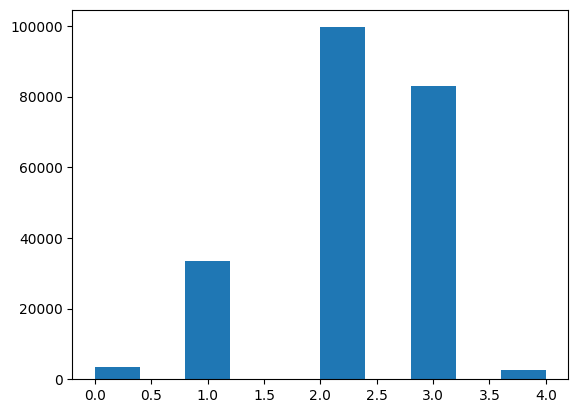

In [8]:
plt.hist(out_values[:,2])

In [48]:
### AVERAGE BATTING ###
x = out_values[:,3]/out_values[:,2]
np.mean(x[~np.isnan(x)])

### AVERAGE AT BATS ###
np.mean(out_values[:,2])

C:\Users\joshm\AppData\Local\Temp\ipykernel_20336\3241492268.py:2: RuntimeWarning: invalid value encountered in divide
  x = out_values[:,3]/out_values[:,2]


2.216546697858557

In [35]:
### CREATE A RANDOM ARRAY OF 1s AND 0s TO SEE HOW THE MODEL COMPARES TO RANDOM GUESSES ###
ypred = np.round(np.random.rand(len(ytest)))
print('Percent predicted to get hit:',np.sum(ypred)/len(ypred))
print('Percent that actually got hit:', np.sum(ytest)/len(ytest))
correct = []
for i in range(len(ypred)):
    if ypred[i]==ytest[i]:
        correct.append(1)
    else:
        correct.append(0)
print('Percent of correct picks:', np.sum(correct)/len(correct))

Percent predicted to get hit: 0.5010757867694284
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5013808606294156


In [79]:
### CREATE AN ARRAY OF PREDICTIONS THAT JUST LOOKS AT THE BATTING AVERAGE AND MULTIPLIES BY AVERAGE AT BATS ###
xtest[:,2][xtest[:,2]==0] = 1
ypred = np.floor(xtest[:,3]/xtest[:,2] * np.mean(xtest[:,2]))
ypred[ypred>2] = 2

print('Percent predicted to get hit:',np.sum(ypred)/len(ypred))
print('Percent that actually got hit:', np.sum(ytest)/len(ytest))
correct = []
for i in range(len(ypred)):
    if ypred[i]==ytest[i]:
        correct.append(1)
    else:
        correct.append(0)
print('Percent of correct picks:', np.sum(correct)/len(correct))

Percent predicted to get hit: 0.050658317276814385
Percent that actually got hit: 0.5562138728323699
Percent of correct picks: 0.5290301862556198


In [36]:
### CREATE LIST OF NO HIT GUESSES TO SEE PERCENT CORRECT ###
ypred = np.array([0]*len(ytest))
print('Percent predicted to get hit:',np.sum(ypred)/len(ypred))
print('Percent that actually got hit:', np.sum(ytest)/len(ytest))
correct = []
for i in range(len(ypred)):
    if ypred[i]==ytest[i]:
        correct.append(1)
    else:
        correct.append(0)
print('Percent of correct picks:', np.sum(correct)/len(correct))

Percent predicted to get hit: 0.0
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.536849710982659


In [9]:
### TESTING NEURAL NETWORK ###
xtrain, xtest, ytrain, ytest = in_values[:160000], in_values[160000:], out_values_cat[:160000], out_values_cat[160000:]

regr = neural_network.MLPClassifier(hidden_layer_sizes=(35) ,random_state=10, max_iter=300, early_stopping=True, solver='sgd').fit(xtrain, np.ravel(ytrain))
ypred = regr.predict(xtest)

In [9]:
### TESTING SVM ###
xtrain, xtest, ytrain, ytest = in_values[:160000], in_values[160000:], out_values_cat[:160000], out_values_cat[160000:]

regr = svm.SVC().fit(xtrain, np.ravel(ytrain))
ypred = regr.predict(xtest)

In [20]:
### TUNING MODEL PARAMETERS ###
from sklearn.model_selection import GridSearchCV
from itertools import product

xtrain, xtest, ytrain, ytest = in_values[:160000], in_values[160000:], out_values_cat[:160000], out_values_cat[160000:]

mlp = neural_network.MLPClassifier(max_iter=150)

neuron1 = np.arange(20, 41, 5)
neuron2 = np.arange(20, 41, 5)

# parameter_space = {
#     'hidden_layer_sizes': list(product(neuron1, neuron2)),
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive']
# }
parameter_space = {
    'hidden_layer_sizes': list(product(neuron1, neuron2)),
}
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3, verbose=75)
clf.fit(xtrain, np.ravel(ytrain))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


KeyboardInterrupt: 

In [10]:
### TRYING MY OWN TUNING MODEL PARAMETERS, OTHER TAKES FOREVER ###
xtrain, xtest, ytrain, ytest = in_values[:160000], in_values[160000:], out_values_cat[:160000], out_values_cat[160000:]

perc_corr, configs = [], []
activation, solver, alpha, learning_rate, learn_rate_init = ['relu', 'tanh'], ['sgd', 'adam'], [0.0001, 0.05], ['constant','adaptive'], [0.001, 0.05, 0.1]
for l in learn_rate_init:
    for learn in learning_rate:
        for a in alpha:
            for act in activation:
                for solve in solver:
                    # for j in range(40, 101):
                    #     for k in range(1, 41):
                    mlp = neural_network.MLPClassifier(hidden_layer_sizes=(35,), random_state=10, max_iter=300, early_stopping=True, solver=solve, activation=act, alpha=a, learning_rate=learn, learning_rate_init=l)
                    mlp.fit(xtrain, np.ravel(ytrain))
                    ypred = mlp.predict(xtest)

                    print('Layers: ({0}). Solver: {1}. Activation: {2}. Alpha: {3}. Learning Rate: {4}  - {5}.'.format(str(35), solve, act, a, learn, l))
                    print('Percent predicted to get hit:',np.sum(ypred)/len(ypred))
                    print('Percent that actually got hit:', np.sum(ytest)/len(ytest))
                    correct = []
                    for i in range(len(ypred)):
                        if ypred[i]==ytest[i]:
                            correct.append(1)
                        else:
                            correct.append(0)
                    print('Percent of correct picks:', np.sum(correct)/len(correct))
                    print('Best Validation Score:', mlp.best_validation_score_)
                    print(' ')
                    perc_corr.append(np.sum(correct)/len(correct))
                    configs.append(act + '-' + solve + '-' + str(35) + '-' + str(a) + '-' + learn + '-' + str(l))

Layers: (35). Solver: sgd. Activation: relu. Alpha: 0.0001. Learning Rate: constant  - 0.001.
Percent predicted to get hit: 0.2679993577392421
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.55
Best Validation Score: 0.554625
 
Layers: (35). Solver: adam. Activation: relu. Alpha: 0.0001. Learning Rate: constant  - 0.001.
Percent predicted to get hit: 0.2911689145793192
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5481535003211304
Best Validation Score: 0.5551875
 
Layers: (35). Solver: sgd. Activation: tanh. Alpha: 0.0001. Learning Rate: constant  - 0.001.
Percent predicted to get hit: 0.3354849068721901
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5473506743737958
Best Validation Score: 0.5554375
 
Layers: (35). Solver: adam. Activation: tanh. Alpha: 0.0001. Learning Rate: constant  - 0.001.
Percent predicted to get hit: 0.22114643545279383
Percent that actually got hit: 0.46315028901734

In [1]:
# Best parameter set
print('Best parameters found:\n', clf.best_params_)

NameError: name 'clf' is not defined

In [41]:
### TESTING RANDOM FOREST (SEEMS TERRIBLE LOL) ###
xtrain, xtest, ytrain, ytest = in_values[:160000], in_values[160000:], out_values_cat[:160000], out_values_cat[160000:]

regr = RandomForestClassifier(n_estimators=1000).fit(xtrain, np.ravel(ytrain))
ypred = regr.predict(xtest)

In [10]:
correct, rand_corr, avg_corr = [], [], []
main_file = pd.DataFrame()

for i in np.arange(0, len(ytest), 18):
    temp_xtest = xtest[i:i+18]
    ypred = regr.predict(temp_xtest)
    ypred[ypred > 1] = 1
    print('Game {0}:'.format(i/18))
    temp_ytest = ytest[i:i+18]
    rand_pred = np.round(np.random.rand(18))
    avg_pred = np.floor(xtest[:,3][i:i+18]/xtest[:,2][i:i+18] * np.mean(xtest[:,2]))
    avg_pred[avg_pred>1] = 1
    avg_pred[avg_pred<1] = 0

    df = pd.DataFrame({'game':i/18, 'pred' : ypred, 'actual' : temp_ytest[:,0], 'prob':regr.predict_proba(temp_xtest)[:,1], 'rand_pred':rand_pred, 'avg_pred':avg_pred})
    try:
        df['rand_pred'] = df['rand_pred'].astype(int)
        df['avg_pred'] = df['avg_pred'].astype(int)
    except:
        print('Conversion Error for Game')
    df = df.sort_values('prob').tail(3)
    print(df)
    if df['pred'].equals(df['actual']):
        correct.append(1)
        df['W/L_model'] = 1
        print('WIN')
    else:
        correct.append(0)
        df['W/L_model'] = 0
        print('LOSS')
    if df['rand_pred'].equals(df['actual']):
        rand_corr.append(1)
        df['W/L_rand'] = 1
    else:
        rand_corr.append(0)
        df['W/L_rand'] = 0
    if df['avg_pred'].equals(df['actual']):
        avg_corr.append(1)
        df['W/L_avg'] = 1
    else:
        avg_corr.append(0)
        df['W/L_avg'] = 0
    print('')
    main_file = pd.concat([main_file, df])
main_file.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\simulated_games.csv", index=False)

Game 0.0:
    game  pred  actual      prob  rand_pred  avg_pred
0    0.0     1       1  0.511992          0         0
11   0.0     1       0  0.542414          1         0
9    0.0     1       0  0.562804          0         0
LOSS

Game 1.0:
   game  pred  actual      prob  rand_pred  avg_pred
9   1.0     1       1  0.525175          0         0
1   1.0     1       1  0.529618          1         0
2   1.0     1       0  0.537633          1         0
LOSS

Game 2.0:
    game  pred  actual      prob  rand_pred  avg_pred
3    2.0     1       0  0.524520          0         0
10   2.0     1       0  0.564863          1         1
9    2.0     1       1  0.584811          0         0
LOSS

Game 3.0:
   game  pred  actual      prob  rand_pred  avg_pred
2   3.0     1       1  0.533280          1         0
6   3.0     1       0  0.533451          0         0
1   3.0     1       1  0.542008          1         0
LOSS

Game 4.0:
   game  pred  actual      prob  rand_pred  avg_pred
0   4.0     1    

C:\Users\joshm\AppData\Local\Temp\ipykernel_14212\2566985596.py:11: RuntimeWarning: invalid value encountered in divide
  avg_pred = np.floor(xtest[:,3][i:i+18]/xtest[:,2][i:i+18] * np.mean(xtest[:,2]))


     game  pred  actual      prob  rand_pred  avg_pred
4   355.0     1       0  0.501692          0         0
16  355.0     1       1  0.505112          0         0
0   355.0     1       0  0.570107          0         0
LOSS

Game 356.0:
     game  pred  actual      prob  rand_pred  avg_pred
3   356.0     1       0  0.507644          0         1
2   356.0     1       1  0.514654          0         0
13  356.0     1       0  0.515612          1         0
LOSS

Game 357.0:
     game  pred  actual      prob  rand_pred  avg_pred
14  357.0     1       0  0.516953          0         0
17  357.0     1       0  0.518081          0         0
0   357.0     1       1  0.560237          1         0
LOSS

Game 358.0:
     game  pred  actual      prob  rand_pred  avg_pred
17  358.0     1       1  0.518790          1         0
9   358.0     1       1  0.540906          0         0
8   358.0     1       0  0.572509          0         0
LOSS

Game 359.0:
     game  pred  actual      prob  rand_pred  av

C:\Users\joshm\AppData\Local\Temp\ipykernel_14212\2566985596.py:11: RuntimeWarning: invalid value encountered in divide
  avg_pred = np.floor(xtest[:,3][i:i+18]/xtest[:,2][i:i+18] * np.mean(xtest[:,2]))


      game  pred  actual      prob  rand_pred  avg_pred
11  1049.0     1       0  0.513826          1         0
13  1049.0     1       1  0.538405          1         0
3   1049.0     1       0  0.544610          1         0
LOSS

Game 1050.0:
      game  pred  actual      prob  rand_pred  avg_pred
3   1050.0     1       1  0.519657          0         0
11  1050.0     1       0  0.535249          0         0
2   1050.0     1       0  0.560380          0         0
LOSS

Game 1051.0:
      game  pred  actual      prob  rand_pred  avg_pred
12  1051.0     1       1  0.512348          0         0
3   1051.0     1       0  0.523497          1         0
10  1051.0     1       1  0.528128          1         0
LOSS

Game 1052.0:
      game  pred  actual      prob  rand_pred  avg_pred
17  1052.0     1       0  0.501775          0         0
3   1052.0     1       1  0.504123          1         0
16  1052.0     1       1  0.514162          0         0
LOSS

Game 1053.0:
      game  pred  actual    

C:\Users\joshm\AppData\Local\Temp\ipykernel_14212\2566985596.py:11: RuntimeWarning: invalid value encountered in divide
  avg_pred = np.floor(xtest[:,3][i:i+18]/xtest[:,2][i:i+18] * np.mean(xtest[:,2]))



Game 1245.0:
     game  pred  actual      prob  rand_pred  avg_pred
0  1245.0     1       1  0.508332          0         0
1  1245.0     1       0  0.512570          0         0
2  1245.0     1       1  0.520490          0         0
LOSS

Game 1246.0:
      game  pred  actual      prob  rand_pred  avg_pred
11  1246.0     1       1  0.516798          0         0
9   1246.0     1       0  0.517671          0         0
5   1246.0     1       1  0.526942          1         0
LOSS

Game 1247.0:
     game  pred  actual      prob  rand_pred  avg_pred
5  1247.0     1       0  0.514059          1         1
2  1247.0     1       0  0.517405          1         0
7  1247.0     1       1  0.534929          1         0
LOSS

Game 1248.0:
     game  pred  actual      prob  rand_pred  avg_pred
1  1248.0     1       0  0.508705          1         0
3  1248.0     1       0  0.518868          1         1
2  1248.0     1       1  0.550564          0         0
LOSS

Game 1249.0:
      game  pred  actual  

C:\Users\joshm\AppData\Local\Temp\ipykernel_14212\2566985596.py:11: RuntimeWarning: invalid value encountered in divide
  avg_pred = np.floor(xtest[:,3][i:i+18]/xtest[:,2][i:i+18] * np.mean(xtest[:,2]))
C:\Users\joshm\AppData\Local\Temp\ipykernel_14212\2566985596.py:11: RuntimeWarning: invalid value encountered in divide
  avg_pred = np.floor(xtest[:,3][i:i+18]/xtest[:,2][i:i+18] * np.mean(xtest[:,2]))


Game 1512.0:
      game  pred  actual      prob  rand_pred  avg_pred
16  1512.0     1       0  0.521021          1         0
8   1512.0     1       0  0.522602          0         1
13  1512.0     1       1  0.542609          1         0
LOSS

Game 1513.0:
      game  pred  actual      prob  rand_pred  avg_pred
14  1513.0     1       1  0.524840          1         0
1   1513.0     1       1  0.535621          1         0
12  1513.0     1       1  0.561752          1         0
WIN

Game 1514.0:
      game  pred  actual      prob  rand_pred  avg_pred
4   1514.0     1       1  0.505763          1         0
12  1514.0     1       0  0.522083          1         0
13  1514.0     1       0  0.525778          0         1
LOSS

Game 1515.0:
      game  pred  actual      prob  rand_pred  avg_pred
13  1515.0     1       1  0.520645          0         0
5   1515.0     1       1  0.533265          0         0
12  1515.0     1       1  0.534970          0         0
WIN

Game 1516.0:
      game  pred 

C:\Users\joshm\AppData\Local\Temp\ipykernel_14212\2566985596.py:11: RuntimeWarning: invalid value encountered in divide
  avg_pred = np.floor(xtest[:,3][i:i+18]/xtest[:,2][i:i+18] * np.mean(xtest[:,2]))


Game 2500.0:
      game  pred  actual      prob  rand_pred  avg_pred
4   2500.0     1       1  0.529854          1         0
12  2500.0     1       1  0.539732          0         0
15  2500.0     1       1  0.577811          1         0
WIN

Game 2501.0:
      game  pred  actual      prob  rand_pred  avg_pred
3   2501.0     1       0  0.530057          1         1
4   2501.0     1       1  0.534160          0         0
13  2501.0     1       0  0.534166          1         1
LOSS

Game 2502.0:
     game  pred  actual      prob  rand_pred  avg_pred
4  2502.0     1       1  0.515161          0         0
3  2502.0     1       0  0.519203          1         0
2  2502.0     1       1  0.568364          0         0
LOSS

Game 2503.0:
     game  pred  actual      prob  rand_pred  avg_pred
9  2503.0     1       0  0.547559          1         0
0  2503.0     1       0  0.556693          0         0
8  2503.0     1       0  0.584718          1         0
LOSS

Game 2504.0:
      game  pred  actual

C:\Users\joshm\AppData\Local\Temp\ipykernel_14212\2566985596.py:11: RuntimeWarning: invalid value encountered in divide
  avg_pred = np.floor(xtest[:,3][i:i+18]/xtest[:,2][i:i+18] * np.mean(xtest[:,2]))



Game 2597.0:
      game  pred  actual      prob  rand_pred  avg_pred
12  2597.0     1       0  0.507774          1         0
15  2597.0     1       0  0.509085          0         1
3   2597.0     1       1  0.532846          0         0
LOSS

Game 2598.0:
      game  pred  actual      prob  rand_pred  avg_pred
14  2598.0     0       0  0.497596          1         0
5   2598.0     1       0  0.514134          1         0
13  2598.0     1       1  0.517323          0         0
LOSS

Game 2599.0:
     game  pred  actual      prob  rand_pred  avg_pred
5  2599.0     1       0  0.514374          0         1
4  2599.0     1       1  0.544534          0         0
3  2599.0     1       1  0.569642          0         0
LOSS

Game 2600.0:
      game  pred  actual      prob  rand_pred  avg_pred
13  2600.0     1       0  0.538281          0         0
1   2600.0     1       1  0.564698          0         0
0   2600.0     1       0  0.576333          1         0
LOSS

Game 2601.0:
      game  pred  

C:\Users\joshm\AppData\Local\Temp\ipykernel_14212\2566985596.py:11: RuntimeWarning: invalid value encountered in divide
  avg_pred = np.floor(xtest[:,3][i:i+18]/xtest[:,2][i:i+18] * np.mean(xtest[:,2]))


Game 3383.0:
      game  pred  actual      prob  rand_pred  avg_pred
14  3383.0     1       1  0.519881          0         0
13  3383.0     1       1  0.541245          1         0
4   3383.0     1       0  0.550074          0         0
LOSS

Game 3384.0:
      game  pred  actual      prob  rand_pred  avg_pred
12  3384.0     0       1  0.496737          0         0
11  3384.0     0       0  0.498655          1         0
3   3384.0     1       1  0.515455          1         0
LOSS

Game 3385.0:
      game  pred  actual      prob  rand_pred  avg_pred
13  3385.0     1       1  0.511124          0         0
11  3385.0     1       1  0.511951          0         0
16  3385.0     1       1  0.519339          0         0
WIN

Game 3386.0:
      game  pred  actual      prob  rand_pred  avg_pred
3   3386.0     1       0  0.505640          1         0
2   3386.0     1       1  0.524748          0         0
14  3386.0     1       1  0.537461          0         0
LOSS

Game 3387.0:
      game  pred

C:\Users\joshm\AppData\Local\Temp\ipykernel_14212\2566985596.py:11: RuntimeWarning: invalid value encountered in divide
  avg_pred = np.floor(xtest[:,3][i:i+18]/xtest[:,2][i:i+18] * np.mean(xtest[:,2]))


Game 3426.0:
      game  pred  actual      prob  rand_pred  avg_pred
10  3426.0     1       1  0.515435          0         0
1   3426.0     1       1  0.517219          1         0
2   3426.0     1       1  0.540896          0         0
WIN

Game 3427.0:
      game  pred  actual      prob  rand_pred  avg_pred
12  3427.0     1       0  0.519714          1         0
2   3427.0     1       1  0.526282          1         0
1   3427.0     1       0  0.549779          1         0
LOSS

Game 3428.0:
      game  pred  actual      prob  rand_pred  avg_pred
13  3428.0     1       1  0.508521          0         0
5   3428.0     1       1  0.508845          1         0
2   3428.0     1       0  0.525659          1         0
LOSS

Game 3429.0:
      game  pred  actual      prob  rand_pred  avg_pred
13  3429.0     1       0  0.519728          1         0
16  3429.0     1       0  0.528978          1         0
1   3429.0     1       0  0.569607          1         0
LOSS

Game 3430.0:
      game  pred

In [21]:
### CREATE CSV TRACKING RUNNING SUM OF WINS ###
df = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\simulated_games.csv")
df = df.drop(['pred','actual','prob','rand_pred','avg_pred'], axis=1).groupby('game', as_index=False).sum()
df.loc[df['W/L_avg'] > 1, 'W/L_avg'], df.loc[df['W/L_model'] > 1, 'W/L_model'], df.loc[df['W/L_rand'] > 1, 'W/L_rand'] = 1, 1, 1
df['W/L_avg'], df['W/L_model'], df['W/L_rand'] = np.cumsum(df['W/L_avg']), np.cumsum(df['W/L_model']), np.cumsum(df['W/L_rand'])
df.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\simulations_cumulative.csv", index=False)

In [83]:
np.sum(correct)/len(correct)

0.0

In [39]:
np.sum(rand_corr)/len(rand_corr)

0.12976878612716763

In [40]:
np.sum(avg_corr)/len(avg_corr)

0.13641618497109825

In [14]:
print('Percent predicted to get hit:',np.sum(ypred)/len(ypred))
print('Percent that actually got hit:', np.sum(ytest)/len(ytest))
correct = []
for i in range(len(ypred)):
    if ypred[i]==ytest[i]:
        correct.append(1)
    else:
        correct.append(0)
print('Percent of correct picks:', np.sum(correct)/len(correct))

Percent predicted to get hit: 0.2679993577392421
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.55


In [42]:
test = pd.DataFrame({'pred' : ypred, 'actual' : ytest[:,0], 'prob':regr.predict_proba(xtest)[:,1]})

,pred,actual,prob
53927,1,0,0.614948
16085,1,1,0.615234
44908,1,0,0.615240
52177,1,0,0.615496
57821,1,1,0.615550
39341,1,1,0.616264
8723,1,0,0.619262
50934,1,1,0.619794
41942,1,0,0.621423
19257,1,1,0.621744


In [8]:
correct = []
for i in range(len(ypred)):
    if ypred[i]==1:
        if ypred[i]==ytest[i]:
            correct.append(1)
        else:
            correct.append(0)
print('Percent of correct picks:', np.sum(correct)/len(correct))

Percent of correct picks: 0.5245341800970583


In [13]:
### TEST TO SEE IDEAL LAYERS ###
perc_corr = []
for j in range(1, 1001):
    regr = neural_network.MLPClassifier(hidden_layer_sizes=(j,) ,random_state=10, max_iter=300, early_stopping=True, solver='sgd').fit(xtrain, np.ravel(ytrain))
    ypred = regr.predict(xtest)

    print('Layers:', j)
    print('Percent predicted to get hit:',np.sum(ypred)/len(ypred))
    print('Percent that actually got hit:', np.sum(ytest)/len(ytest))
    correct = []
    for i in range(len(ypred)):
        if ypred[i]==ytest[i]:
            correct.append(1)
        else:
            correct.append(0)
    print('Percent of correct picks:', np.sum(correct)/len(correct))
    print(' ')
    perc_corr.append(np.sum(correct)/len(correct))

Layers: 1
Percent predicted to get hit: 0.28134232498394346
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5427906229929351
 
Layers: 2
Percent predicted to get hit: 0.2796563904945408
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.546660244059088
 
Layers: 3
Percent predicted to get hit: 0.3689627488760437
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5404945407835581
 
Layers: 4
Percent predicted to get hit: 0.33670520231213874
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.546034039820167
 
Layers: 5
Percent predicted to get hit: 0.24322414900449582
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.548699421965318
 
Layers: 6
Percent predicted to get hit: 0.34405908798972384
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5440751445086706
 
Layers: 7
Percent predicted to get hit: 0.344669235709698

c:\Users\joshm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Layers: 279
Percent predicted to get hit: 0.2537411689145793
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5490044958253051
 
Layers: 280
Percent predicted to get hit: 0.3090077071290944
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5471419396274888
 
Layers: 281
Percent predicted to get hit: 0.29425176621708415
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5480892742453436
 
Layers: 282
Percent predicted to get hit: 0.3065189466923571
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5484104046242775
 
Layers: 283
Percent predicted to get hit: 0.2874116891457932
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5491811175337187
 
Layers: 284
Percent predicted to get hit: 0.2706326268464997
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5492614001284521
 
Layers: 285
Percent predicted to get hit: 0.2

c:\Users\joshm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Layers: 386
Percent predicted to get hit: 0.2682080924855491
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5497270391779062
 


In [228]:
test = pd.DataFrame({'pred' : ypred, 'actual' : ytest[:,0], 'prob':regr.predict_proba(xtest)[:,1]})

In [232]:
test[(test['pred']==1)&(test['actual']==0)]

,pred,actual,prob
9,1,0,0.523662
10,1,0,0.506816
11,1,0,0.523662
20,1,0,0.523662
26,1,0,0.518154
...,...,...,...
62257,1,0,0.523662
62258,1,0,0.514355
62260,1,0,0.509715
62267,1,0,0.523662


In [268]:
### ATTEMPTING LOGISTIC REGRESSION ###
regr = linear_model.LogisticRegression(random_state=5, solver='newton-cholesky').fit(xtrain, ytrain)
ypred = regr.predict(xtest)

print('Percent predicted to get hit:',np.sum(ypred)/len(ypred))
print('Percent that actually got hit:', np.sum(ytest)/len(ytest))
correct = []
for i in range(len(ypred)):
    if ypred[i]==ytest[i]:
        correct.append(1)
    else:
        correct.append(0)
print('Percent of correct picks:', np.sum(correct)/len(correct))

c:\Users\joshm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Percent predicted to get hit: 0.2751766217084136
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5484425176621709


In [3]:
query = """ 
    SELECT a.*
    FROM main_models.event_offense_stats as a
"""
df: pd.DataFrame = conn.sql(query).df()
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,game_id,event_key,team_id,player_id,baserunner,plate_appearances,at_bats,hits,singles,doubles,triples,home_runs,total_bases,strikeouts,walks,intentional_walks,hit_by_pitches,sacrifice_hits,sacrifice_flies,reached_on_errors,reached_on_interferences,inside_the_park_home_runs,ground_rule_doubles,infield_hits,on_base_opportunities,on_base_successes,runs_batted_in,grounded_into_double_plays,double_plays,triple_plays,batting_outs,balls_in_play,balls_batted,trajectory_fly_ball,trajectory_ground_ball,trajectory_line_drive,trajectory_pop_up,trajectory_unknown,trajectory_known,trajectory_broad_air_ball,trajectory_broad_ground_ball,trajectory_broad_unknown,trajectory_broad_known,bunts,batted_distance_plate,batted_distance_infield,batted_distance_outfield,batted_distance_unknown,batted_distance_known,fielded_by_battery,fielded_by_infielder,fielded_by_outfielder,fielded_by_known,fielded_by_unknown,batted_angle_left,batted_angle_right,batted_angle_middle,batted_angle_unknown,batted_angle_known,batted_location_plate,batted_location_right_infield,batted_location_middle_infield,batted_location_left_infield,batted_location_left_field,batted_location_center_field,batted_location_right_field,batted_location_unknown,batted_location_known,batted_balls_pulled,batted_balls_opposite_field,runs,times_reached_base,stolen_bases,caught_stealing,picked_off,picked_off_caught_stealing,outs_on_basepaths,unforced_outs_on_basepaths,outs_avoided_on_errors,advances_on_wild_pitches,advances_on_passed_balls,advances_on_balks,advances_on_unspecified_plays,advances_on_defensive_indifference,advances_on_errors,plate_appearances_while_on_base,balls_in_play_while_running,balls_in_play_while_on_base,batter_total_bases_while_running,batter_total_bases_while_on_base,extra_base_advance_attempts,bases_advanced,bases_advanced_on_balls_in_play,surplus_bases_advanced_on_balls_in_play,outs_on_extra_base_advance_attempts,pitches,swings,swings_with_contact,strikes,strikes_called,strikes_swinging,strikes_foul,strikes_foul_tip,strikes_in_play,strikes_unknown,balls,balls_called,balls_intentional,balls_automatic,unknown_pitches,pitchouts,pitcher_pickoff_attempts,catcher_pickoff_attempts,pitches_blocked_by_catcher,pitches_with_runners_going,passed_balls,wild_pitches,balks,left_on_base,left_on_base_with_two_outs,stolen_bases_second,stolen_bases_third,stolen_bases_home,caught_stealing_second,caught_stealing_third,caught_stealing_home,stolen_base_opportunities,stolen_base_opportunities_second,stolen_base_opportunities_third,stolen_base_opportunities_home,picked_off_first,picked_off_second,picked_off_third,times_force_on_runner,times_lead_runner,times_next_base_empty,extra_base_chances,extra_bases_taken
0,PIT200806110,539588729,WAS,dukee001,Batter,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,4,1,1,2,1,0,0,0,1,0,2,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,PIT200806110,539588733,PIT,sancf001,Batter,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,6,2,1,3,1,1,0,0,1,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,PIT200806110,539588735,PIT,doumr001,Batter,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,3,2,2,2,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,PIT200806110,539588736,PIT,nadyx001,Batter,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,PIT200806120,539588929,WAS,boona001,Batter,1,1,1,1,0,0,0,1,0,0,0

In [6]:
np.max(pd.to_numeric(df['game_id'].str[3:7]))

2023